## Preparation
---

In [376]:
# https://www.youtube.com/watch?v=QIUxPv5PJOY

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt 

import yfinance as yf



In [377]:
# Get the stock quote
import datetime

start_date = datetime.datetime(2012, 1, 1)
end_date = datetime.datetime(2019, 12, 17)

df = yf.download('AAPL', start=start_date, end= end_date)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.466093,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.533086,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.672229,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.804702,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.784389,394024400
...,...,...,...,...,...,...
2019-12-10,67.150002,67.517502,66.464996,67.120003,65.476601,90420400
2019-12-11,67.202499,67.775002,67.125000,67.692497,66.035088,78756800
2019-12-12,66.945000,68.139999,66.830002,67.864998,66.203369,137310400



---

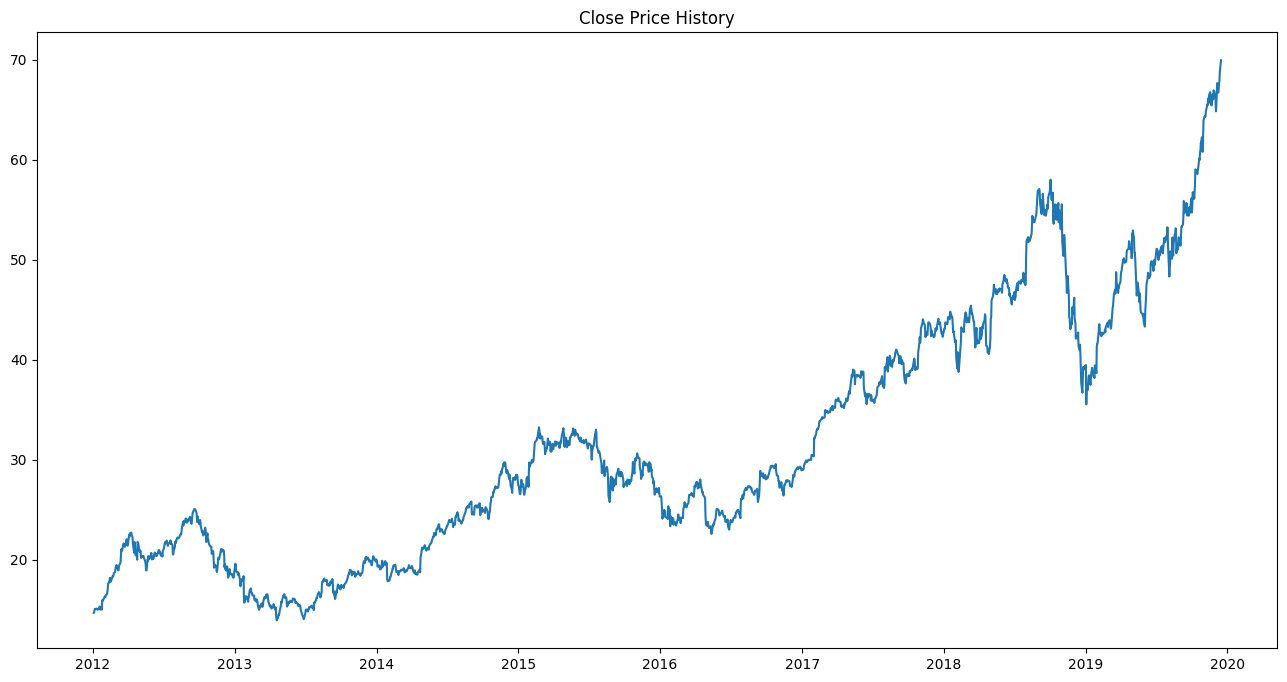

In [378]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.show()

## Data Processing
---

In [379]:
## Interval內 8成為records

data = df[['Close']]

dataset = data.values  # Take out the index col
training_data_len = math.ceil(len(dataset)*0.8)   ## Can be repalced by sklearn 
training_data_len

1602

In [380]:
# Scale the data

scaler = MinMaxScaler(feature_range=(0,1)) # 用泥scale 野既模組

scaled_data = scaler.fit_transform(dataset)



In [381]:
interval = 90

In [382]:
# Spilt the data

train_data = scaled_data[0:training_data_len]
x_train = []
y_train = []
delay = 8

for i in range(interval+delay, len(train_data)):
    x_train.append(train_data[i-interval-delay:i-delay,0])
    y_train.append(train_data[i,0])   


    if i == 60:
        print(x_train)
        


In [383]:
## Convert the x_train and y_train 
x_train, y_train = np.array(x_train), np.array(y_train)



In [384]:
## Reshape the data for LSTM model

i,j = x_train.shape
x_train_reshaped = np.reshape(x_train,(i,j,1))
print(x_train_reshaped.shape)


(1504, 90, 1)


## Modeling
---

In [385]:
# Build the LSTM Model

model = Sequential()

num_cells = 70
# model.add(LSTM(50, return_sequences=True, input_shape= (j,1)))
model.add(LSTM(num_cells , return_sequences=False, input_shape=(j,1)))

model.add(Dense(25))
model.add(Dense(1))

In [386]:
## Comple the model
model.compile(optimizer='adam', loss = 'mean_squared_error')


In [387]:
num_epochs = 3
model.fit(x_train, y_train, batch_size = 1, epochs=num_epochs)

Epoch 1/3
1504/1504 [==============================] - 29s 17ms/step - loss: 0.0013
Epoch 2/3
1504/1504 [==============================] - 26s 17ms/step - loss: 8.3352e-04
Epoch 3/3
1504/1504 [==============================] - 27s 18ms/step - loss: 7.9091e-04


In [388]:
test_data = scaled_data[training_data_len-interval:]

x_test = []
y_test = dataset[training_data_len:,]

for i in range (interval,len(test_data)):
    x_test.append(test_data[i-interval:i,0])


In [389]:
x_test = np.array(x_test)

In [390]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [391]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

13/13 [==============================] - 1s 9ms/step


## Plot the Data
---

/var/folders/0c/4yyxy27966j8h86h_vwsy3680000gn/T/ipykernel_76375/643579412.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


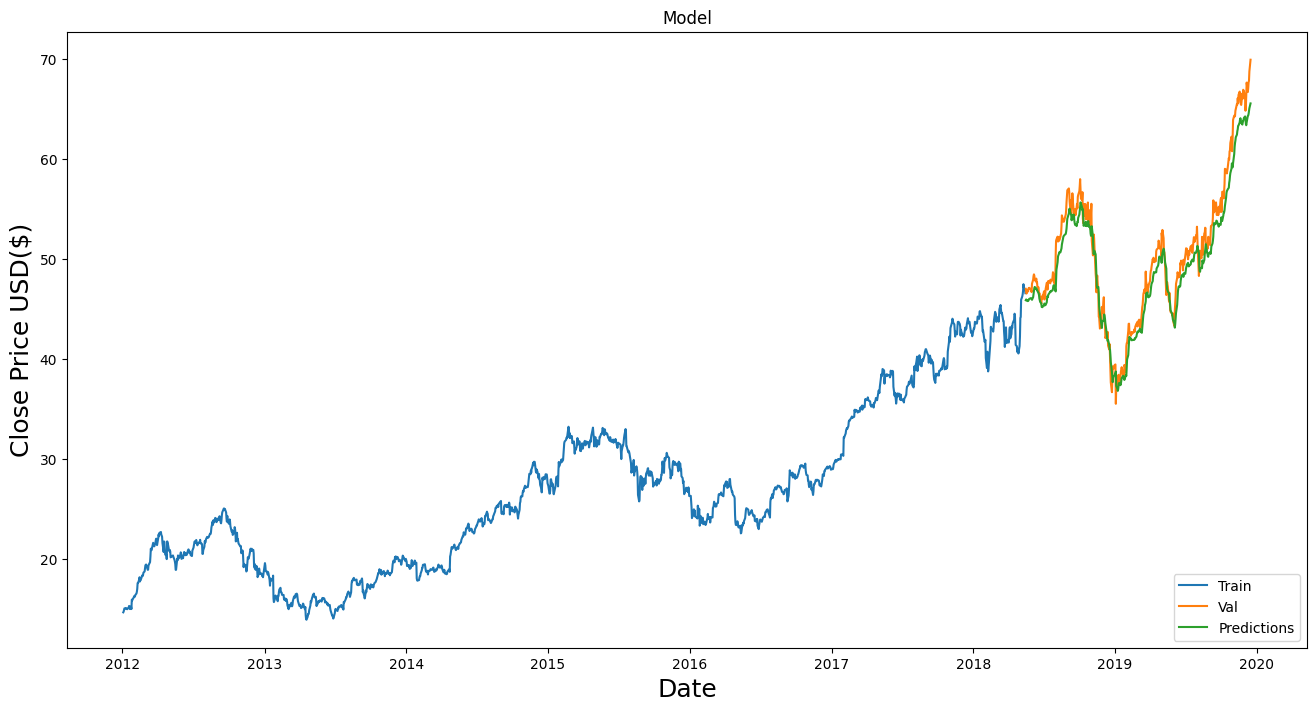

In [392]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize = (16,8))
plt.title('Model')
plt.xlabel('Date',fontsize = 18)
plt.ylabel('Close Price USD($)', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
plt.legend(['Train','Val','Predictions'], loc = 'lower right')
plt.show()




## Result in Data

---

In [393]:
valid

,Close,Predictions
Date,,
2018-05-16,47.044998,45.904922
2018-05-17,46.747501,45.984081
2018-05-18,46.577499,45.918846
2018-05-21,46.907501,45.815861
2018-05-22,46.790001,45.881538
...,...,...
2019-12-10,67.120003,64.382645
2019-12-11,67.692497,64.550880
2019-12-12,67.864998,64.859810


In [394]:
valid.to_csv('{0}days_{1}Cells_{2}Epoches_{3}daysdelay.csv'.format(interval,num_cells, num_epochs, delay), index=True)
